# Fashion-MNIST classification

In [1]:
import time

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
classes = [
    'top', 'trousers', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [4]:
data_set = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(data_set, list(range(55000))),
    batch_size=250, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(data_set, list(range(55000, 60000))),
    batch_size=250)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root='../data/fashion-mnist',
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()),
    batch_size=250)

In [5]:
x = np.array(train_loader.dataset.dataset.train_data)
y = np.array(train_loader.dataset.dataset.train_labels)

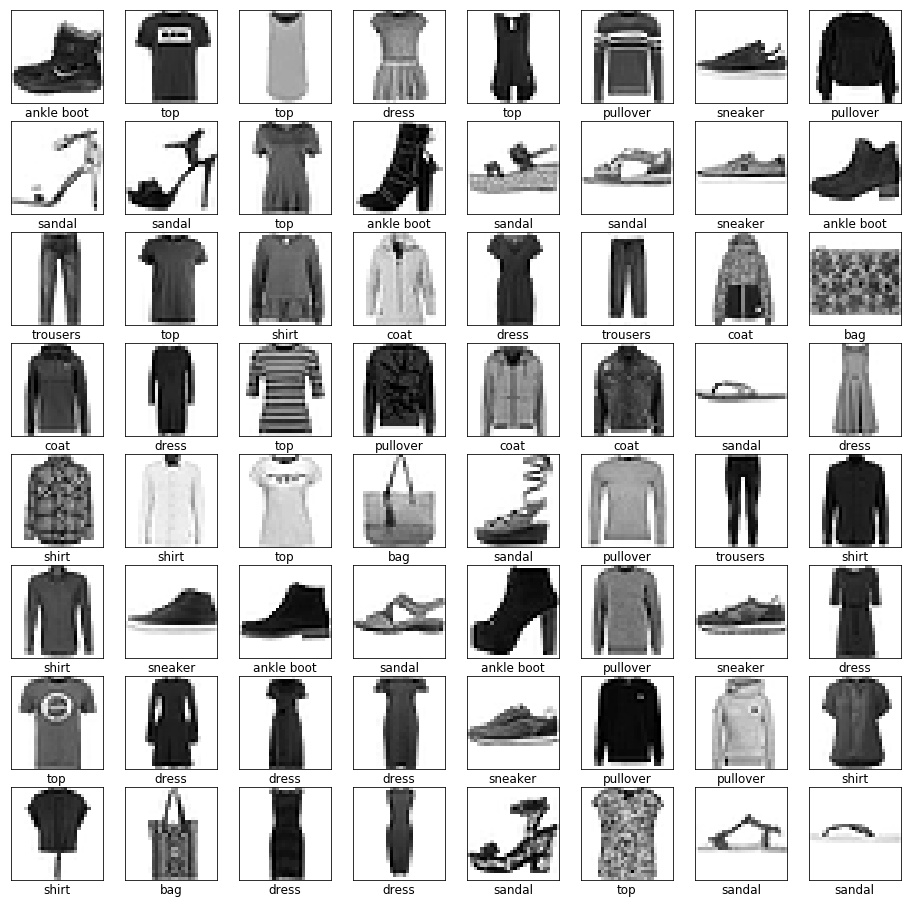

In [6]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(x[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

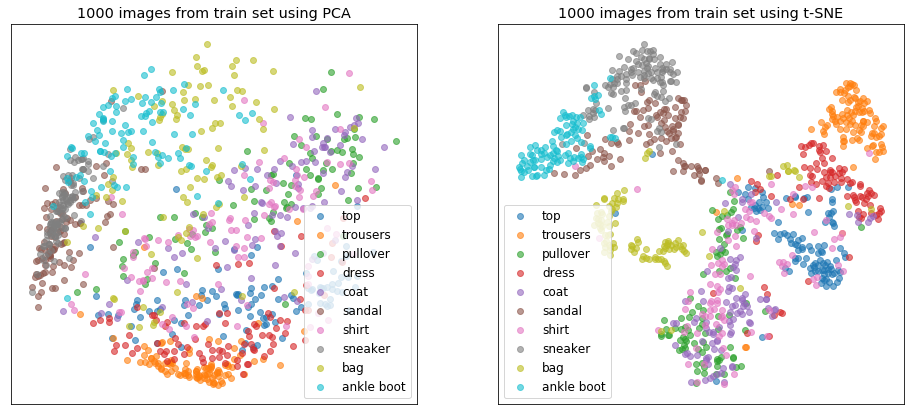

In [7]:
plt.figure(figsize=(16, 7))
for i, (algorithm_name, algorithm) in enumerate([
        ('PCA', PCA(n_components=2)), ('t-SNE', TSNE(n_components=2))]):
    x_reduced = algorithm.fit_transform(x[:1000].reshape(-1, 784))
    y_reduced = y[:1000]
    data = [(class_, x_reduced[y_reduced == i]) for i, class_ in enumerate(classes)]
    
    plt.subplot(1, 2, i + 1)
    for class_, points in data:
        plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label=class_)
    plt.title(f'1000 images from train set using {algorithm_name}')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

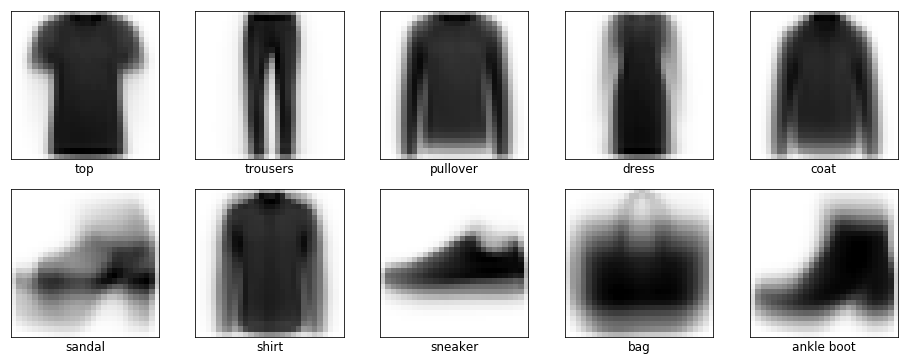

In [8]:
centroids = [(class_, np.mean(x[y == i], axis=0)) for i, class_ in enumerate(classes)]

plt.figure(figsize=(16, 6))
for i, (class_, image) in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [9]:
def plot_history(history):
    plt.figure(figsize=(16, 5))
    for i, (name, key) in enumerate([('accuracy', 'acc'), ('loss', 'loss')]):
        plt.subplot(1, 2, i + 1)
        plt.plot(history['epoch'], history[key], label=f'training {name}')
        plt.plot(history['epoch'], history[f'val_{key}'], label=f'validation {name}')
        plt.title(f'{name} during training')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel(name)
    plt.show()


def plot_confusion_matrix(cm, classes=classes):
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, cmap=plt.cm.binary)
    threshold = np.max(cm) / 2
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(
                j, i, cm[i, j], color='white' if cm[i, j] > threshold else 'black',
                horizontalalignment='center', verticalalignment='center')
    plt.title('confusion matrix')
    plt.xlabel('predicted class')
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.ylabel('true class')
    plt.yticks(range(len(classes)), classes)
    plt.show()

In [10]:
class Classifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_loader, val_loader, epochs):
        self.to(self.device)
        history = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
        for epoch in range(1, epochs+1):
            self.train()
            start_time = time.time()
            loss, acc = 0, 0
            for data, target in train_loader:
                # Batch training step
                self.optimizer.zero_grad()
                data, target = data.to(self.device), target.to(self.device)
                output = self(data)
                loss_ = self.loss(output, target)
                loss_.backward()
                self.optimizer.step()
                # Calculate metrics for batch
                loss += float(loss_) * len(data)
                acc += int((output.argmax(dim=1) == target).sum())
            # Calculate metrics for epoch
            loss /= len(train_loader.dataset)
            acc /= len(train_loader.dataset)
            val_loss, val_acc = self.evaluate(val_loader)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['loss'].append(loss)
            history['acc'].append(acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - loss: {loss:.4f} - acc: {acc:.4f}'
                f' - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')
        return history

    def evaluate(self, data_loader):
        self.to(self.device)
        self.eval()
        loss, acc = 0, 0
        for data, target in data_loader:
            data, target = data.to(self.device), target.to(self.device)
            output = self(data)
            loss += float(self.loss(output, target)) * len(data)
            acc += int((output.argmax(dim=1) == target).sum())
        loss /= len(data_loader.dataset)
        acc /= len(data_loader.dataset)
        return loss, acc

    def predict(self, data_loader):
        self.to(self.device)
        self.eval()
        prediction, target = [], []
        for data, target_ in data_loader:
            data = data.to(self.device)
            prediction.extend(self(data).argmax(dim=1).cpu())
            target.extend(target_)
        return np.array(target), np.array(prediction)

In [11]:
class MultilayerPerceptron(Classifier):

    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(784, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
            # torch.nn.Softmax(dim=1)
        ])
        
        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [12]:
model = MultilayerPerceptron()

In [13]:
history = model.fit(train_loader, val_loader, epochs=50)

[ 1/50] 3.8s - loss: 0.7418 - acc: 0.7418 - val_loss: 0.4967 - val_acc: 0.8298
[ 2/50] 3.7s - loss: 0.5125 - acc: 0.8204 - val_loss: 0.4267 - val_acc: 0.8470
[ 3/50] 3.8s - loss: 0.4651 - acc: 0.8341 - val_loss: 0.3980 - val_acc: 0.8564
[ 4/50] 3.6s - loss: 0.4399 - acc: 0.8429 - val_loss: 0.3802 - val_acc: 0.8606
[ 5/50] 3.6s - loss: 0.4188 - acc: 0.8473 - val_loss: 0.3675 - val_acc: 0.8658
[ 6/50] 3.6s - loss: 0.4050 - acc: 0.8542 - val_loss: 0.3579 - val_acc: 0.8738
[ 7/50] 3.7s - loss: 0.3922 - acc: 0.8589 - val_loss: 0.3554 - val_acc: 0.8728
[ 8/50] 3.7s - loss: 0.3859 - acc: 0.8595 - val_loss: 0.3455 - val_acc: 0.8750
[ 9/50] 3.9s - loss: 0.3767 - acc: 0.8624 - val_loss: 0.3341 - val_acc: 0.8748
[10/50] 3.6s - loss: 0.3659 - acc: 0.8659 - val_loss: 0.3340 - val_acc: 0.8728
[11/50] 3.8s - loss: 0.3621 - acc: 0.8677 - val_loss: 0.3358 - val_acc: 0.8774
[12/50] 3.8s - loss: 0.3586 - acc: 0.8679 - val_loss: 0.3244 - val_acc: 0.8776
[13/50] 3.6s - loss: 0.3525 - acc: 0.8709 - val_loss

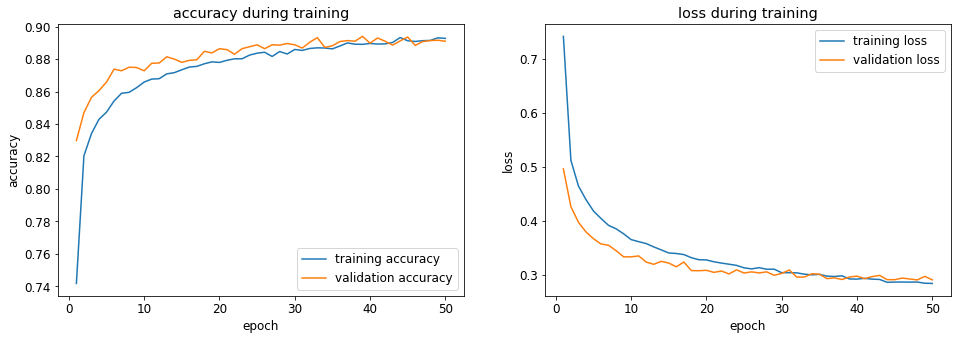

In [14]:
plot_history(history)

In [15]:
print(
    'Accuracy:\n'
    f'  - train set:      {100 * model.evaluate(train_loader)[1]:.2f}%\n'
    f'  - validation set: {100 * model.evaluate(val_loader)[1]:.2f}%\n'
    f'  - test set:       {100 * model.evaluate(test_loader)[1]:.2f}%')

Accuracy:
  - train set:      92.29%
  - validation set: 89.10%
  - test set:       88.72%


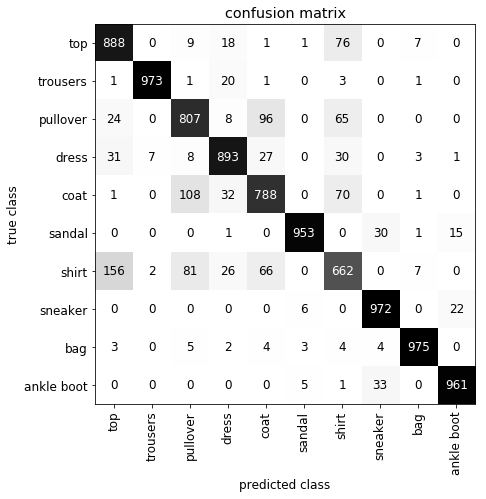

In [16]:
cm = confusion_matrix(*model.predict(test_loader))
plot_confusion_matrix(cm)

In [17]:
class ConvolutionalNet(Classifier):

    def __init__(self):
        super().__init__()
        self.conv_layers = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        ])
        self.dense_layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(150, 10),
            # torch.nn.Softmax(dim=1),
        ])

        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size()[0], -1)
        for layer in self.dense_layers:
            x = layer(x)
        return x

In [18]:
model = ConvolutionalNet()

In [19]:
history = model.fit(train_loader, val_loader, epochs=50)

[ 1/50] 6.4s - loss: 0.9310 - acc: 0.6538 - val_loss: 0.5404 - val_acc: 0.7842
[ 2/50] 5.6s - loss: 0.5891 - acc: 0.7800 - val_loss: 0.4492 - val_acc: 0.8306
[ 3/50] 5.5s - loss: 0.5084 - acc: 0.8150 - val_loss: 0.4037 - val_acc: 0.8468
[ 4/50] 5.6s - loss: 0.4517 - acc: 0.8366 - val_loss: 0.3606 - val_acc: 0.8656
[ 5/50] 5.6s - loss: 0.4195 - acc: 0.8491 - val_loss: 0.3371 - val_acc: 0.8712
[ 6/50] 5.6s - loss: 0.3927 - acc: 0.8592 - val_loss: 0.3133 - val_acc: 0.8832
[ 7/50] 5.6s - loss: 0.3696 - acc: 0.8671 - val_loss: 0.3073 - val_acc: 0.8856
[ 8/50] 5.5s - loss: 0.3547 - acc: 0.8707 - val_loss: 0.2937 - val_acc: 0.8866
[ 9/50] 5.6s - loss: 0.3371 - acc: 0.8782 - val_loss: 0.3006 - val_acc: 0.8836
[10/50] 5.6s - loss: 0.3234 - acc: 0.8818 - val_loss: 0.2738 - val_acc: 0.8936
[11/50] 5.6s - loss: 0.3190 - acc: 0.8837 - val_loss: 0.2705 - val_acc: 0.8978
[12/50] 5.6s - loss: 0.3052 - acc: 0.8889 - val_loss: 0.2768 - val_acc: 0.8956
[13/50] 5.5s - loss: 0.2973 - acc: 0.8924 - val_loss

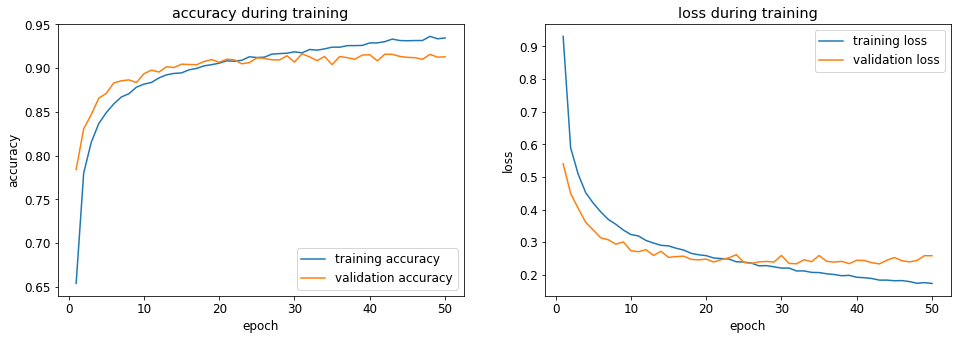

In [20]:
plot_history(history)

In [21]:
print(
    'Accuracy:\n'
    f'  - train set:      {100 * model.evaluate(train_loader)[1]:.2f}%\n'
    f'  - validation set: {100 * model.evaluate(val_loader)[1]:.2f}%\n'
    f'  - test set:       {100 * model.evaluate(test_loader)[1]:.2f}%')

Accuracy:
  - train set:      95.91%
  - validation set: 91.30%
  - test set:       91.06%


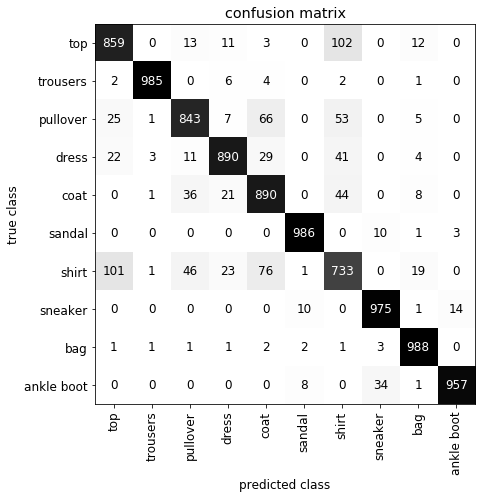

In [22]:
cm = confusion_matrix(*model.predict(test_loader))
plot_confusion_matrix(cm)